#Analysis of San Francisco Bay Water Temperature

##Last Updated: 01/2023

>I am an avid open water swimmer based in the San Francisco Bay Area. Something that has a large impact on my day-to-day life is the water temperature of the San Francisco Bay. I prefer to swim without a wetsuit, and therefore the daily water temperate has a great impact on the total amount of time that I'm able to spend in the water without risking hypothermia.

>Water temperatures are a source of great debate in the local open water community, so I thought that taking a data-driven look at long term historical trends as well as recent data would make for a fun activity.

>All data is pulled from the hourly temperature data as measured by the buoy located on the west end of Crissy Field near the south tower of the Golden Gate Bridge (Station ID #9414290). This data is freely available on the [NOAA Website](https://tidesandcurrents.noaa.gov/physocean.html?bdate=20220414&edate=20230413&units=standard&timezone=GMT&id=9414290&interval=h&action=data), and I've included all of the hourly data dating back to April 1994 in my analysis. The water in the Aquatic Park Cove (the most popular open water swimming spot in the area) is usually a couple of degrees F colder than this buoy. So, while the absolute temperature values may be a degree or two higher than what most people experience in their daily swims, I believe that the general trends and comparisons should translate.

>![buoy_location.jpg](images/buoy_location.jpg)



In [1]:
import pymc as pm
import arviz as az

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import datetime as dt

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Importing all of the yearly data files and stitching them together into a single Pandas dataframe
d = pd.read_csv("data/water_temp/1994.csv")
for year in np.arange(start = 1995, stop = 2023):
    file = "data/water_temp/"+str(year)+".csv"
    year_data = pd.read_csv(file)
    d = pd.concat([d,year_data])


In [3]:
#Cleaning up the dataframe
d.rename(columns = {d.columns[0]:"date", d.columns[1]:"time", d.columns[2]: "temp"}, inplace = True)
d = d.loc[:,["date", "time", "temp"]]
d.loc[d.temp == "-","temp"] = np.nan
d.temp = d.temp.astype("float")
d.reset_index(inplace = True)

In [4]:
#Formatting year, month, day columns
d.date = pd.to_datetime(d.date)
d["year"] = d.date.dt.year
d["month"] = d.date.dt.month
d["day"] = d.date.dt.day
d["doy"] = d.date.dt.dayofyear

d.head

<bound method NDFrame.head of         index       date   time  temp  year  month  day  doy
0           0 1994-04-14  00:00  55.4  1994      4   14  104
1           1 1994-04-14  01:00  55.0  1994      4   14  104
2           2 1994-04-14  02:00  55.2  1994      4   14  104
3           3 1994-04-14  03:00  55.4  1994      4   14  104
4           4 1994-04-14  04:00  55.4  1994      4   14  104
...       ...        ...    ...   ...   ...    ...  ...  ...
230596   7025 2023-01-31  17:00  54.3  2023      1   31   31
230597   7026 2023-01-31  18:00  54.3  2023      1   31   31
230598   7027 2023-01-31  19:00  54.7  2023      1   31   31
230599   7028 2023-01-31  20:00  55.0  2023      1   31   31
230600   7029 2023-01-31  21:00  55.2  2023      1   31   31

[230601 rows x 8 columns]>

>Woah! We've got quite a bit of data to work with here. Again, this is hourly readings over a 28 year period, so we will have to apply some summary statistics in order to make any meaningful sense of this data.


>The core of this data is in the 'temp' column, which includes the hourly temperature readings in &deg;F. The original data also came with the date and time columns, and I've used the date column to create separate columns for different date features (i.e. year, month, day, day of year) in order to make some of the upcoming summaries possible.

##First, lets take a look at some simple monthly averages.

In [5]:
#Calculating montly averages, year by year
monthly_average = d.groupby(by = ["year","month"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
monthly_average.sort_values(by = ["year", "month"], inplace = True)
monthly_average.reset_index(inplace = True)
monthly_average.dropna(inplace = True)
#monthly_average.year = pd.Categorical(monthly_average.year)

#Calculating the average of the monthly averages across all of the years
ma2 = monthly_average.groupby(by = "month", as_index = False).agg(Mean = ("Mean", np.mean))
ma2.sort_values(by = "month", inplace = True)
ma2.reset_index(inplace = True)

ma2

,index,month,Mean
0,0,1,52.377371
1,1,2,53.200513
2,2,3,54.045114
3,3,4,54.637911
4,4,5,55.557050
5,5,6,57.180054
6,6,7,59.498634
7,7,8,61.022001
8,8,9,61.329098
9,9,10,59.627547


Text(0, 0.5, 'Average Temperature (°F)')

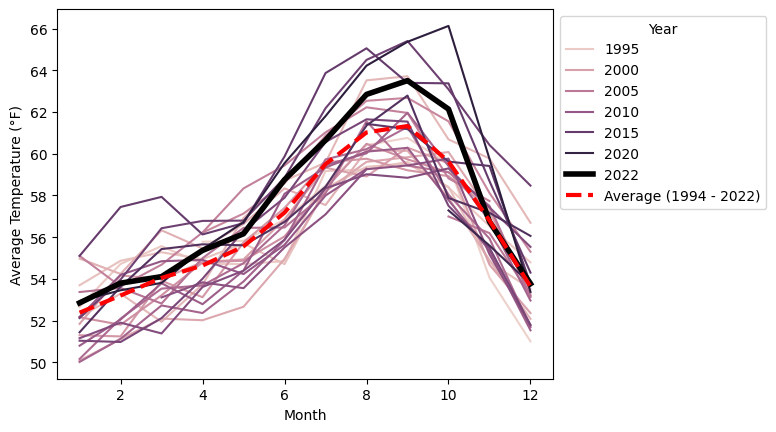

In [6]:
ax = sns.lineplot(data = monthly_average.loc[monthly_average.year<2022,:], x = "month", y = "Mean", hue = "year")
sns.lineplot(
    data = monthly_average.loc[monthly_average.year == 2022,:], 
    x = "month", y = "Mean", 
    linewidth = 4, color = "black", label = "2022"
    )
sns.lineplot(
    data = ma2, x = "month", y = "Mean", 
    linewidth = 3, color = "red", linestyle = "dashed", label = "Average (1994 - 2022)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title = "Year")
ax.set_xlabel("Month")
ax.set_ylabel("Average Temperature (\N{DEGREE SIGN}F)")


>Upon a quick glance, there are a few noteworthy features of this chart:
>- On average, September is the warmest month as measured by the buoy, with an average temperature of 61.3&deg;F.  
>- On the other side of the equation, January is the coldest, with an average temperature of 52.4&deg;F.  
>- Generally, this location takes much longer to warm up than it does to cool off. With September being the warmest and January being the coldest, that 4 month period of rapid cooling. This is followed by an 8 month period of slow and steady warming.  
>- Most of 2022 was warmer than average, especially during the late summer and early fall. However, this was followed by a steep decline in temperature in the months of November and December that brought the 2022 line back to to the historical average.  

##Next, lets take a look at this data from a daily perspective.

In [7]:
#Calculating averages for each day for every DOY in the dataset (within each year)
daily_average = d.groupby(by = ["year", "month", "day","doy"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
daily_average.sort_values(by = ["year","month","doy"], inplace = True)
daily_average.reset_index(inplace = True)

#Daily average across all years
da2 = daily_average.groupby(by = ["doy"], as_index = False).agg(Mean = ("Mean", np.mean), Sd = ("Mean", np.std), N = ("Mean", len))
da2.sort_values(by = ["doy"], inplace = True)
da2.reset_index(inplace = True)

#5 Warmest and coldest days of the year on average
da2.sort_values(by = "Mean", inplace = False)

,index,doy,Mean,Sd,N
365,365,366,52.127778,0.896233,6
5,5,6,52.231196,1.595073,23
2,2,3,52.273620,1.578136,23
22,22,23,52.278399,1.672193,23
6,6,7,52.279545,1.650236,23
...,...,...,...,...,...
249,249,250,61.543547,2.019115,28
248,248,249,61.554755,2.066233,28
240,240,241,61.593750,2.288417,28
242,242,243,61.597743,2.314068,28


>It would appear that, on average, the coldest water temperature days in the year are during the third week of January at around 52.1&deg;F. This is ommitting the last day of the leap years (DOY 366), there is much more uncertainty associated with that day due to the fact that it has ~75% fewer data points than all other days.

>On the other hand, all of the warmest average days of the year tend to occur between the 240th and 250th days of the year, which is right at the turn of August into September. Average temperatures during this time are around 61.6&deg;F.

***

>Next, we will produce a plot similar to the one above using this daily average data. However, this visualization will look slighlty different. Instead of plotting individual lines for each year, I will use the <code>az.plot_hdi()</code> function from the [Arviz](https://www.arviz.org/en/latest/) library to display a colored band around the mean that represesents the majority of the observed temperature data for each date. This band will be set at the 90% interval, meaning that temperature values that fall below the 5th percentile or the above the 95th of the observed data won't be captured.

>Additionally, I will make dedicated lines that represent the daily average data from 2022, what has been collected so far in 2023, and the average across all years.

c:\Users\arcot\dev\venv\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


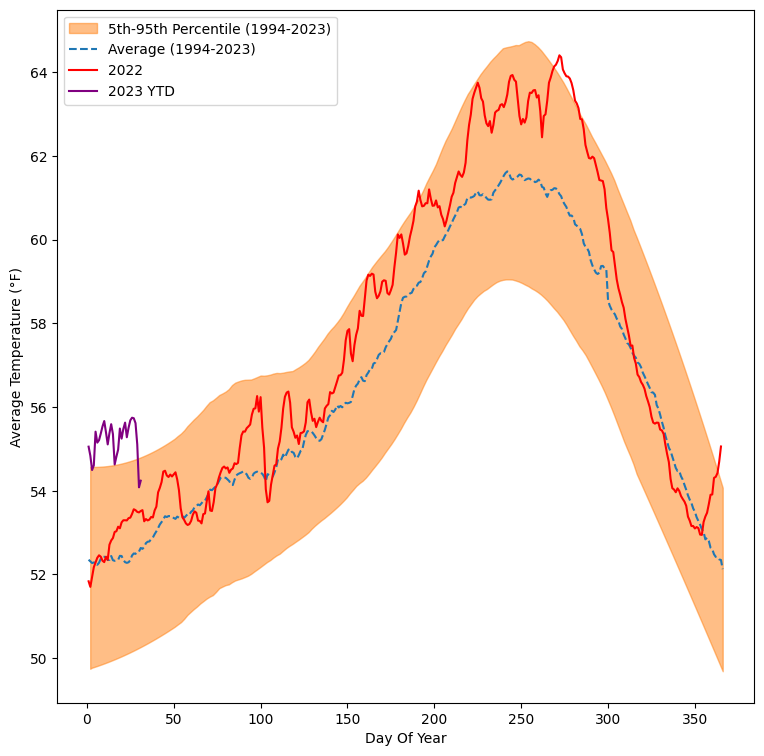

In [8]:
#Creating a year x day matrix of mean temperature values for use in the az.plot_hdi function
interval_data = pd.DataFrame(
    daily_average.loc[
        daily_average.year<=2022,:
    ].pivot(
        index = "year",columns = "doy", values = "Mean"
        )
)
#Imputing missing values (average temperature from all other years)
interval_data = interval_data.fillna(interval_data.mean())

fig, ax = plt.subplots(figsize = (9,9))
#Creating the 90% interval shaded region
az.plot_hdi(
    x = da2.doy, y = interval_data, 
    hdi_prob = 0.9, fill_kwargs = {"label": "5th-95th Percentile (1994-2023)"}
    )
#Average daily temperatures across all years
plt.plot(da2.doy, da2.Mean, label = "Average (1994-2023)", linestyle = "--")
#Average daily temperature from 2022
plt.plot(
    daily_average.loc[daily_average.year == 2022,"doy"],
    daily_average.loc[daily_average.year == 2022,"Mean"], 
    color = "Red", label = ("2022")
    )
#What has been collected so far in 2023
plt.plot(
    daily_average.loc[daily_average.year == 2023,"doy"],
    daily_average.loc[daily_average.year == 2023,"Mean"], 
    color = "Purple", label = ("2023 YTD")
    )
ax.set_xlabel("Day Of Year")
ax.set_ylabel("Average Temperature (\N{DEGREE SIGN}F)")
ax.legend()
plt.show()

>This graph corraborates the conclusions drawn regarding 2022 from the previous graph of montly averages - 2022 was mostly warmer than average, especially during the late summer and early fall. The warmer temperatures held steady and were even on a short term uptrend through the end of September. In fact, the warmest 8 days of the year were all consecutive, lasting from September 25th through October 2nd.  

>This was follwed by a steep and consistent decline in average temperatures that lasted through mid-December, bottoming out on December 20th at 52.9&deg;F.* After this date, the buoy measured a steep rebound in water temperatures that may have been due, at least in part, to the start of an air temperature warming trend and very high precipitation that was seen at the end of December 2022 into the beginning of January 2023. 

>![dec_2022_temperature_trend.jpg](images/dec_2022_temperature_trend.jpg)

>*<em>December 20th was not the coldest water temperature day of 2022. That title belongs to January 2nd, 2022 at 51.7&deg;F.</em>

***

>As of today (early January 2023), this buoy is reporting temperatures that are much warmer than average. Looking back at the monthly average data, January 2023 has so far yielded an average water temperature of 55.0&deg;F compared to a historical average of 52.3&deg;F. Within the available data, this average is only topped by January 2004 and January 2015. We have yet to finish out January, so we will see if the temperatures regress towards the average, or if the rainfall brought on an early longer-term warming trend.

In [ ]:
#Some code that I'm saving for future analyses

# #Calculating yearly averages
# yearly_average = d.groupby(by = ["year"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
# yearly_average.sort_values(by = ["year"], inplace = True)
# yearly_average.reset_index(inplace = True)

# #Calculating hourly averages
# hourly_average = d.groupby(by = ["time"], as_index = False).agg(Mean = ("temp", np.mean), Sd = ("temp", np.std))
# hourly_average.sort_values(by = ["time"], inplace = True)
# hourly_average.reset_index(inplace = True)

# #Yearly MinMax
# yearly_minmax = d.groupby(["year"], as_index = False).agg(Min = ("temp", np.min), Max = ("temp", np.max))
# yearly_minmax.sort_values(by = ["year"], inplace = True)
# yearly_minmax.reset_index(inplace = True)
# yearly_minmax["diff"] = yearly_minmax.Max - yearly_minmax.Min
